# HEOM 2: Dynamics in Fenna-Mathews-Olsen complex (FMO)

## Introduction

In this example notebook we outline how to employ the HEOM to
solve the FMO photosynthetic complex dynamics.

We aim to replicate the results in reference [https://www.pnas.org/content/106/41/17255](https://pubmed.ncbi.nlm.nih.gov/19815512/)
and compare them to a Bloch-Redfield (perturbative) solution.

This demonstrates how to to employ the solver for multiple baths, as well as showing how a
quantum environment reduces the effect of pure dephasing.

## Setup

In [1]:
import contextlib
import time

import numpy as np
from matplotlib import pyplot as plt

from qutip import Qobj, about, basis, brmesolve, expect, liouvillian, mesolve
from qutip.core.environment import DrudeLorentzEnvironment, system_terminator
from qutip.solver.heom import HEOMSolver

%matplotlib inline

## Helper functions

In [2]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [3]:
# Solver options:

options = {
    "nsteps": 15000,
    "store_states": True,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

And let us set up the system Hamiltonian and bath parameters:

In [4]:
# System Hamiltonian:
#
# We use the Hamiltonian employed in
# https://www.pnas.org/content/106/41/17255 and operate
# in units of GHz:

Hsys = 30 * 2 * np.pi * Qobj([
    [200, -87.7, 5.5, -5.9, 6.7, -13.7, -9.9],
    [-87.7, 320, 30.8, 8.2, 0.7, 11.8, 4.3],
    [5.5, 30.8, 0, -53.5, -2.2, -9.6, 6.0],
    [-5.9, 8.2, -53.5, 110, -70.7, -17.0, -63.3],
    [6.7, 0.7, -2.2, -70.7, 270, 81.1, -1.3],
    [-13.7, 11.8, -9.6, -17.0, 81.1, 420, 39.7],
    [-9.9, 4.3, 6.0, -63.3, -1.3, 39.7, 230],
])

In [5]:
# Bath parameters

lam = 35 * 30 * 2 * np.pi
gamma = 1 / 166e-6
T = 300 * 0.6949 * 30 * 2 * np.pi
beta = 1 / T

## Plotting the environment spectral density and correlation functions

Let's quickly plot the spectral density and environment correlation functions so that we can see what they look like.

In [6]:
env = DrudeLorentzEnvironment(T=T, lam=lam, gamma=gamma)

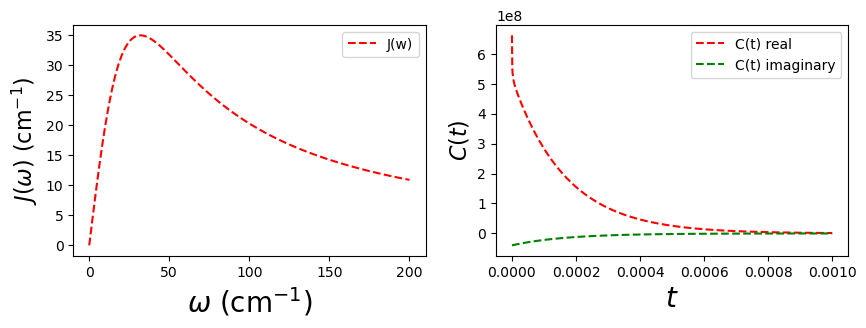

In [7]:
wlist = np.linspace(0, 200 * 30 * 2 * np.pi, 100)
tlist = np.linspace(0, 1e-3, 1000)

J = env.spectral_density(wlist) / (30 * 2 * np.pi)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10, 3))

fig.subplots_adjust(hspace=0.1)  # reduce space between plots

# Spectral density plot:

axes[0].plot(wlist / (30 * 2 * np.pi), J, color='r', ls='--', label="J(w)")
axes[0].set_xlabel(r'$\omega$ (cm$^{-1}$)', fontsize=20)
axes[0].set_ylabel(r"$J(\omega)$ (cm$^{-1}$)", fontsize=16)
axes[0].legend()

# Correlation plot:

axes[1].plot(
    tlist, np.real(env.correlation_function(tlist, 10)),
    color='r', ls='--', label="C(t) real",
)
axes[1].plot(
    tlist, np.imag(env.correlation_function(tlist, 10)),
    color='g', ls='--', label="C(t) imaginary",
)
axes[1].set_xlabel(r'$t$', fontsize=20)
axes[1].set_ylabel(r"$C(t)$", fontsize=16)
axes[1].legend();

## Solve for the dynamics with the HEOM

Now let us solve for the evolution of this system using the HEOM.

In [8]:
# We start the excitation at site 1:
rho0 = basis(7, 0) * basis(7, 0).dag()

# HEOM solver options:
#
# Note: We set Nk=0 (i.e. a single correlation expansion term
#       per bath) and rely on the terminator to correct detailed
#       balance.
NC = 4  # Use NC=8 for more precise results
Nk = 0

Q_list = []
Ltot = liouvillian(Hsys)
env_approx, delta = env.approximate(
    method="matsubara", Nk=Nk, compute_delta=True
)
for m in range(7):
    Q = basis(7, m) * basis(7, m).dag()
    Q_list.append(Q)
    Ltot += system_terminator(Q, delta)

In [9]:
with timer("RHS construction time"):
    HEOMMats = HEOMSolver(Hsys, [(env_approx, Q) for Q in Q_list],
                          NC, options=options)

with timer("ODE solver time"):
    outputFMO_HEOM = HEOMMats.run(rho0, tlist)

RHS construction time: 0.03495335578918457
 [          0%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.21s / Remaining 00:00:00:20

 [          1%           ] Elapsed 0.23s / Remaining 00:00:00:22

 [          1%           ] Elapsed 0.25s / Remaining 00:00:00:25

 [          1%           ] Elapsed 0.25s / Remaining 00:00:00:25

 [          1%           ] Elapsed 0.28s / Remaining 00:00:00:27

 [          1%           ] Elapsed 0.30s / Remaining 00:00:00:29

 [          1%           ] Elapsed 0.30s / Remaining 00:00:00:29

 [          1%           ] Elapsed 0.32s / Remaining 00:00:00:31

 [          1%           ] Elapsed 0.32s / Remaining 00:00:00:31

 [          1%           ] Elapsed 0.34s / Remaining 00:00:00:33

 [          2%           ] Elapsed 0.34s / Remaining 00:00:00:16

 [          2%           ] Elapsed 0.34s / Remaining 00:00:00:16

 [          2%           ] Elapsed 0.37s / Remaining 00:00:00:17

 [          2%           ] Elapsed 0.37s / Remaining 00:00:00:17

 [          2%           ] Elapsed 0.37s / Remaining 00:00:00:17

 [          2%           ] Elapsed 0.39s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.39s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.39s / Remaining 00:00:00:19

 [          2%           ] Elapsed 0.41s / Remaining 00:00:00:20

 [          2%           ] Elapsed 0.41s / Remaining 00:00:00:20

 [*         3%           ] Elapsed 0.41s / Remaining 00:00:00:13

 [*         3%           ] Elapsed 0.41s / Remaining 00:00:00:13

 [*         3%           ] Elapsed 0.44s / Remaining 00:00:00:14

 [*         3%           ] Elapsed 0.44s / Remaining 00:00:00:14

 [*         3%           ] Elapsed 0.44s / Remaining 00:00:00:14

 [*         3%           ] Elapsed 0.44s / Remaining 00:00:00:14

 [*         3%           ] Elapsed 0.46s / Remaining 00:00:00:14

 [*         3%           ] Elapsed 0.46s / Remaining 00:00:00:14

 [*         3%           ] Elapsed 0.46s / Remaining 00:00:00:14

 [*         3%           ] Elapsed 0.46s / Remaining 00:00:00:14

 [*         4%           ] Elapsed 0.46s / Remaining 00:00:00:11

 [*         4%           ] Elapsed 0.49s / Remaining 00:00:00:11

 [*         4%           ] Elapsed 0.49s / Remaining 00:00:00:11

 [*         4%           ] Elapsed 0.49s / Remaining 00:00:00:11

 [*         4%           ] Elapsed 0.49s / Remaining 00:00:00:11

 [*         4%           ] Elapsed 0.49s / Remaining 00:00:00:11

 [*         4%           ] Elapsed 0.51s / Remaining 00:00:00:12

 [*         4%           ] Elapsed 0.51s / Remaining 00:00:00:12

 [*         4%           ] Elapsed 0.51s / Remaining 00:00:00:12

 [*         4%           ] Elapsed 0.51s / Remaining 00:00:00:12

 [*         5%           ] Elapsed 0.52s / Remaining 00:00:00:09

 [*         5%           ] Elapsed 0.54s / Remaining 00:00:00:10

 [*         5%           ] Elapsed 0.54s / Remaining 00:00:00:10

 [*         5%           ] Elapsed 0.54s / Remaining 00:00:00:10

 [*         5%           ] Elapsed 0.54s / Remaining 00:00:00:10

 [*         5%           ] Elapsed 0.54s / Remaining 00:00:00:10

 [*         5%           ] Elapsed 0.54s / Remaining 00:00:00:10

 [*         5%           ] Elapsed 0.54s / Remaining 00:00:00:10

 [*         5%           ] Elapsed 0.56s / Remaining 00:00:00:10

 [*         5%           ] Elapsed 0.57s / Remaining 00:00:00:10

 [*         6%           ] Elapsed 0.57s / Remaining 00:00:00:08

 [*         6%           ] Elapsed 0.57s / Remaining 00:00:00:08

 [*         6%           ] Elapsed 0.57s / Remaining 00:00:00:08

 [*         6%           ] Elapsed 0.57s / Remaining 00:00:00:08

 [*         6%           ] Elapsed 0.57s / Remaining 00:00:00:08

 [*         6%           ] Elapsed 0.59s / Remaining 00:00:00:09

 [*         6%           ] Elapsed 0.59s / Remaining 00:00:00:09

 [*         6%           ] Elapsed 0.59s / Remaining 00:00:00:09

 [*         6%           ] Elapsed 0.59s / Remaining 00:00:00:09

 [*         6%           ] Elapsed 0.59s / Remaining 00:00:00:09

 [**        7%           ] Elapsed 0.60s / Remaining 00:00:00:07

 [**        7%           ] Elapsed 0.62s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.62s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.62s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.62s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.62s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.62s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.62s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.62s / Remaining 00:00:00:08

 [**        7%           ] Elapsed 0.64s / Remaining 00:00:00:08

 [**        8%           ] Elapsed 0.65s / Remaining 00:00:00:07

 [**        8%           ] Elapsed 0.65s / Remaining 00:00:00:07

 [**        8%           ] Elapsed 0.65s / Remaining 00:00:00:07

 [**        8%           ] Elapsed 0.65s / Remaining 00:00:00:07

 [**        8%           ] Elapsed 0.65s / Remaining 00:00:00:07

 [**        8%           ] Elapsed 0.65s / Remaining 00:00:00:07

 [**        8%           ] Elapsed 0.65s / Remaining 00:00:00:07

 [**        8%           ] Elapsed 0.67s / Remaining 00:00:00:07

 [**        8%           ] Elapsed 0.67s / Remaining 00:00:00:07

 [**        8%           ] Elapsed 0.67s / Remaining 00:00:00:07

 [**        9%           ] Elapsed 0.68s / Remaining 00:00:00:06

 [**        9%           ] Elapsed 0.68s / Remaining 00:00:00:06

 [**        9%           ] Elapsed 0.68s / Remaining 00:00:00:06

 [**        9%           ] Elapsed 0.68s / Remaining 00:00:00:06

 [**        9%           ] Elapsed 0.68s / Remaining 00:00:00:06

 [**        9%           ] Elapsed 0.68s / Remaining 00:00:00:06

 [**        9%           ] Elapsed 0.70s / Remaining 00:00:00:07

 [**        9%           ] Elapsed 0.70s / Remaining 00:00:00:07

 [**        9%           ] Elapsed 0.70s / Remaining 00:00:00:07

 [**        9%           ] Elapsed 0.70s / Remaining 00:00:00:07

 [**       10%           ] Elapsed 0.71s / Remaining 00:00:00:06

 [**       10%           ] Elapsed 0.71s / Remaining 00:00:00:06

 [**       10%           ] Elapsed 0.71s / Remaining 00:00:00:06

 [**       10%           ] Elapsed 0.71s / Remaining 00:00:00:06

 [**       10%           ] Elapsed 0.71s / Remaining 00:00:00:06

 [**       10%           ] Elapsed 0.73s / Remaining 00:00:00:06

 [**       10%           ] Elapsed 0.73s / Remaining 00:00:00:06

 [**       10%           ] Elapsed 0.73s / Remaining 00:00:00:06

 [**       10%           ] Elapsed 0.73s / Remaining 00:00:00:06

 [**       10%           ] Elapsed 0.73s / Remaining 00:00:00:06

 [***      11%           ] Elapsed 0.73s / Remaining 00:00:00:05

 [***      11%           ] Elapsed 0.74s / Remaining 00:00:00:05

 [***      11%           ] Elapsed 0.74s / Remaining 00:00:00:05

 [***      11%           ] Elapsed 0.74s / Remaining 00:00:00:05

 [***      11%           ] Elapsed 0.76s / Remaining 00:00:00:06

 [***      11%           ] Elapsed 0.76s / Remaining 00:00:00:06

 [***      11%           ] Elapsed 0.76s / Remaining 00:00:00:06

 [***      11%           ] Elapsed 0.76s / Remaining 00:00:00:06

 [***      11%           ] Elapsed 0.76s / Remaining 00:00:00:06

 [***      11%           ] Elapsed 0.76s / Remaining 00:00:00:06

 [***      12%           ] Elapsed 0.76s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.77s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.77s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.77s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.80s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.80s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.80s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.80s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.81s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.81s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.81s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.81s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.83s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.83s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.83s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.83s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.83s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.83s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.83s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.83s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.84s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.86s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.86s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.86s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.86s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.86s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.86s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.86s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.86s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.87s / Remaining 00:00:00:05

 [***      15%           ] Elapsed 0.89s / Remaining 00:00:00:05

 [***      15%           ] Elapsed 0.89s / Remaining 00:00:00:05

 [***      15%           ] Elapsed 0.89s / Remaining 00:00:00:05

 [***      15%           ] Elapsed 0.89s / Remaining 00:00:00:05

 [***      15%           ] Elapsed 0.89s / Remaining 00:00:00:05

 [***      15%           ] Elapsed 0.89s / Remaining 00:00:00:05

 [***      15%           ] Elapsed 0.89s / Remaining 00:00:00:05

 [***      15%           ] Elapsed 0.89s / Remaining 00:00:00:05

 [***      15%           ] Elapsed 0.89s / Remaining 00:00:00:05

 [***      15%           ] Elapsed 0.89s / Remaining 00:00:00:05

 [****     16%           ] Elapsed 0.90s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.96s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.96s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.96s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.96s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.96s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.97s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.97s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.97s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.97s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 0.99s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 0.99s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 0.99s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 0.99s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 0.99s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 1.00s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 1.00s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 1.00s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 1.00s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 1.00s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.02s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.02s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.02s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.02s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.02s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.02s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.03s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.03s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.03s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.03s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.03s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.05s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.05s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.05s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.05s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.05s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.05s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.06s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.06s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.06s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.08s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.08s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.08s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.08s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.08s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.08s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.08s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.09s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.09s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.09s / Remaining 00:00:00:04

 [*****    22%           ] Elapsed 1.09s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.11s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.11s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.11s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.11s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.11s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.11s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.11s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.12s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.12s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.12s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.12s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.14s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.14s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.14s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.14s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.14s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.14s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.14s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.14s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.15s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.15s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.15s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.17s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.17s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.17s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.17s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.17s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.17s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.17s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.18s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.18s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.18s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.20s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.20s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.20s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.20s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.20s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.20s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.21s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.21s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.21s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.21s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.21s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.23s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.23s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.23s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.23s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.23s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.23s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.24s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.24s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.24s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.24s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.24s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.26s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.26s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.26s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.26s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.26s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.26s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.26s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.27s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.27s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.27s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.27s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.27s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.30s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.30s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.31s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.31s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.31s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.31s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.31s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.31s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.31s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.33s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.33s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.33s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.33s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.34s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.34s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.34s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.34s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.34s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.34s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.34s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.34s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.34s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.36s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.36s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.37s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.37s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.37s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.37s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.37s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.37s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.37s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.37s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.37s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.37s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.39s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.42s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.45s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.50s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.50s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.53s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.53s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.53s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.53s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.53s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.53s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.54s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.54s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.54s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.54s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.54s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.56s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.56s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.56s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.56s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.57s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.57s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.57s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.57s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.57s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.57s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.57s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.59s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.59s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.59s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.59s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.60s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.60s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.60s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.60s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.60s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.60s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.60s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.60s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.62s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.63s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.63s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.63s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.63s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.63s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.63s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.63s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.63s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.63s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.63s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.63s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.63s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.64s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.66s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.66s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.66s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.66s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.66s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.66s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.66s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.66s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.67s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.67s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.67s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.67s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.67s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.70s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.70s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.70s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.71s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.71s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.71s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.71s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.71s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.71s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.71s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.71s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.73s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.74s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.74s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.74s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.74s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.74s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.74s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.74s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.74s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.74s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.74s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.75s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.75s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.75s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.77s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.77s / Remaining 00:00:00:02

[*********45%           ] Elapsed 1.77s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.77s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.77s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.77s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.77s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.77s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.78s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.78s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.78s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.78s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.78s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.80s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.80s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.80s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.80s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 1.80s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 1.80s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 1.80s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 1.81s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 1.81s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 1.81s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 1.81s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 1.81s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 1.81s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 1.81s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 1.85s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 1.85s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 1.85s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 1.85s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 1.85s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 1.85s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 1.85s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 1.85s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 1.85s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 1.86s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.10s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.10s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.10s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.10s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.13s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.13s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.13s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.21s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.21s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.21s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.21s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.21s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.21s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.22s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.22s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.22s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.22s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.22s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.24s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.24s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.24s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.24s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.24s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.24s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.27s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.29s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.29s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.29s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.31s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.31s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.31s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.31s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.31s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.31s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.31s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.31s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.34s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.35s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.35s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.35s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.35s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.35s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.35s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.35s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.35s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.35s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.36s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.36s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.36s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.36s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.36s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.36s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.38s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.38s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.42s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.43s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.43s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.43s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.43s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.48s / Remaining 00:00:00:00

[*********73%*****      ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.55s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.07s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.07s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.07s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.07s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.07s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.07s / Remaining 00:00:00:00

[*********97%********** ] Elapsed 3.07s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.08s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.08s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.09s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.09s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.09s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.09s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.09s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.09s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.13s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.13s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.13s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.13s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.13s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.13s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.13s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.13s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.13s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.13s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.14s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.14s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.14s / Remaining 00:00:00:00

 Total run time:   3.14s
ODE solver time: 3.1414339542388916


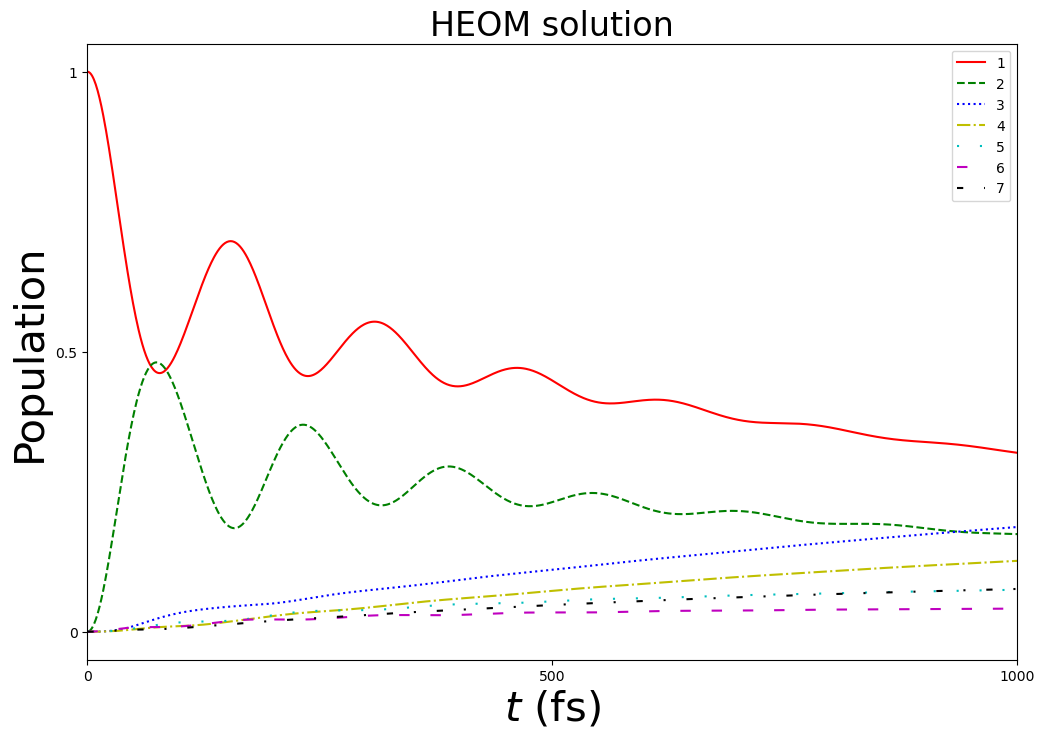

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))

colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
linestyles = [
    '-', '--', ':', '-.',
    (0, (1, 10)), (0, (5, 10)), (0, (3, 10, 1, 10)),
]

for m in range(7):
    Q = basis(7, m) * basis(7, m).dag()
    axes.plot(
        np.array(tlist) * 1e6,
        np.real(expect(outputFMO_HEOM.states, Q)),
        label=m + 1,
        color=colors[m % len(colors)],
        linestyle=linestyles[m % len(linestyles)],
    )
    axes.set_xlabel(r'$t$ (fs)', fontsize=30)
    axes.set_ylabel(r"Population", fontsize=30)
    axes.locator_params(axis='y', nbins=6)
    axes.locator_params(axis='x', nbins=6)

axes.set_title('HEOM solution', fontsize=24)
axes.legend(loc=0)
axes.set_xlim(0, 1000)
plt.yticks([0.0, 0.5, 1], [0, 0.5, 1])
plt.xticks([0.0, 500, 1000], [0, 500, 1000]);

## Comparison with Bloch-Redfield solver

Now let us solve the same problem using the Bloch-Redfield solver. We will see that the Bloch-Redfield technique fails to model the oscillation of population of the states that we saw in the HEOM.

In the next section, we will examine the role of pure dephasing in the evolution to understand why this happens.

In [11]:
with timer("BR ODE solver time"):
    outputFMO_BR = brmesolve(
        Hsys, rho0, tlist,
        a_ops=[[Q, env] for Q in Q_list],
        options=options,
    )

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.52s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.53s / Remaining 00:00:00:00

 Total run time:   0.53s
BR ODE solver time: 0.5713698863983154


And now let's plot the Bloch-Redfield solver results:

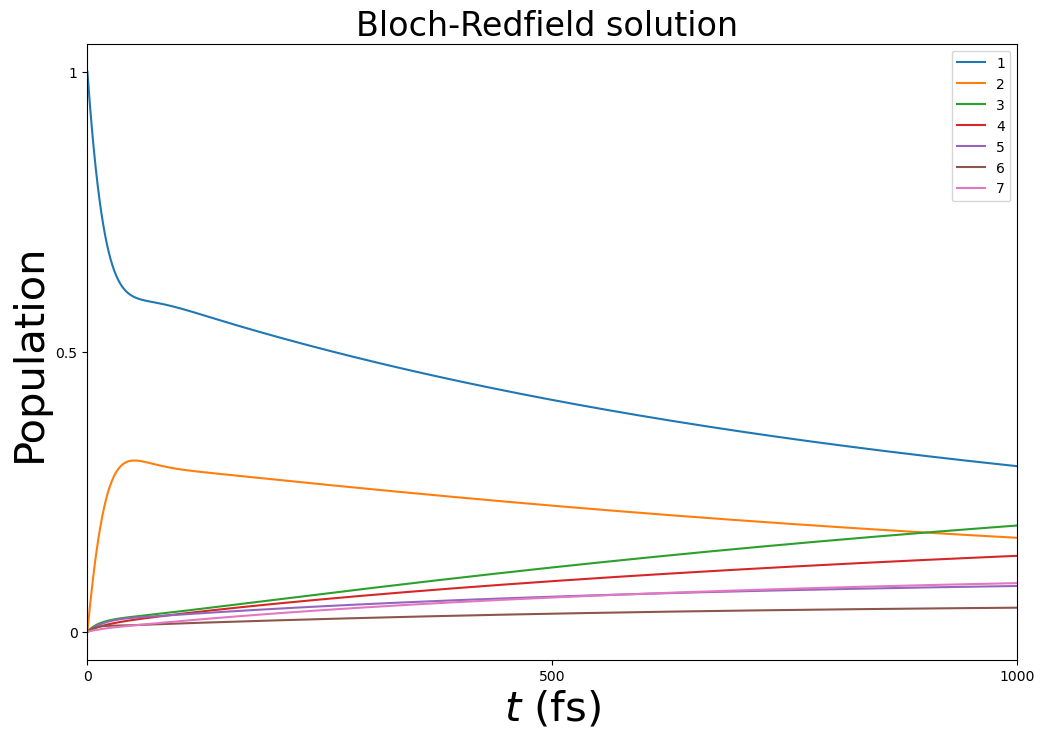

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))

for m, Q in enumerate(Q_list):
    axes.plot(tlist * 1e6, expect(outputFMO_BR.states, Q), label=m + 1)

axes.set_xlabel(r'$t$ (fs)', fontsize=30)
axes.set_ylabel(r"Population", fontsize=30)

axes.set_title('Bloch-Redfield solution ', fontsize=24)
axes.legend()
axes.set_xlim(0, 1000)
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.xticks([0, 500, 1000], [0, 500, 1000]);

Notice how the oscillations are gone and the populations decay much more rapidly.

Next let us try to understand why.

## Role of pure dephasing

It is useful to construct the various parts of the Bloch-Redfield master equation explicitly and to solve them using the Master equation solver, `mesolve`. We will do so and show that it is the pure-dephasing terms which suppresses coherence in these oscillations.

First we will write a function to return the list of collapse operators for a given system, either with or without the dephasing operators:

In [13]:
def J0_dephasing():
    """ Under-damped brownian oscillator dephasing probability.

        This returns the limit as w -> 0 of J0(w) * n_th(w, T) / T.
    """
    return 2 * lam * gamma / gamma**2

In [14]:
def get_collapse(H, T, dephasing=1):
    """ Calculate collapse operators for a given system H and
        temperature T.
    """
    all_energy, all_state = H.eigenstates(sort="low")
    Nmax = len(all_energy)

    Q_list = [basis(Nmax, n) * basis(Nmax, n).dag() for n in range(Nmax)]

    collapse_list = []

    for Q in Q_list:
        for j in range(Nmax):
            for k in range(j + 1, Nmax):
                Deltajk = abs(all_energy[k] - all_energy[j])
                if abs(Deltajk) > 0:
                    rate = np.abs(
                        Q.matrix_element(all_state[j].dag(), all_state[k])
                    ) ** 2 * env.power_spectrum(Deltajk)
                    if rate > 0.0:
                        # emission:
                        collapse_list.append(
                            np.sqrt(rate) * all_state[j] * all_state[k].dag()
                        )

                    rate = np.abs(
                        Q.matrix_element(all_state[k].dag(), all_state[j])
                    ) ** 2 * env.power_spectrum(-Deltajk)
                    if rate > 0.0:
                        # absorption:
                        collapse_list.append(
                            np.sqrt(rate) * all_state[k] * all_state[j].dag()
                        )

        if dephasing:
            for j in range(Nmax):
                rate = (
                    np.abs(
                        Q.matrix_element(all_state[j].dag(), all_state[j])
                    ) ** 2 * env.power_spectrum(0) / 2
                )
                if rate > 0.0:
                    # emission:
                    collapse_list.append(
                        np.sqrt(rate) * all_state[j] * all_state[j].dag()
                    )

    return collapse_list

Now we are able to switch the pure dephasing terms on and off.

Let us starting by including the dephasing operators. We expect to see the same behaviour that we saw when using the Bloch-Redfield solver.

In [15]:
# dephasing terms on, we recover the full BR solution:

with timer("Building the collapse operators"):
    collapse_list = get_collapse(Hsys, T=T, dephasing=True)

with timer("ME ODE solver"):
    outputFMO_ME = mesolve(Hsys, rho0, tlist, collapse_list)

Building the collapse operators: 0.030080080032348633


ME ODE solver: 0.19999289512634277


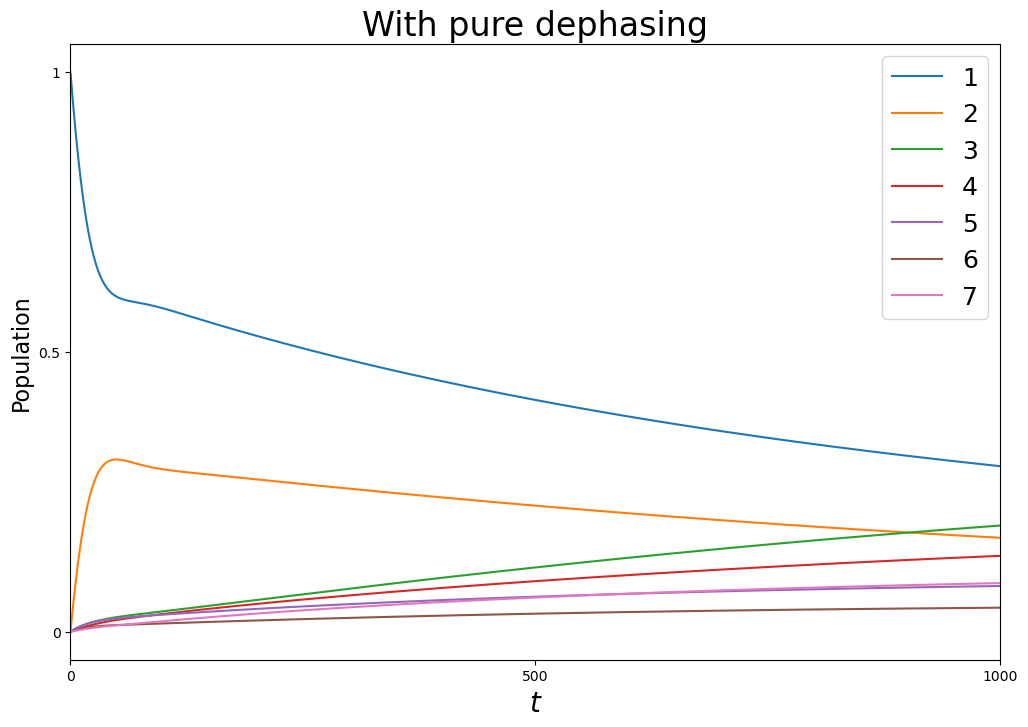

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))

for m, Q in enumerate(Q_list):
    axes.plot(tlist * 1e6, expect(outputFMO_ME.states, Q), label=m + 1)

axes.set_xlabel(r'$t$', fontsize=20)
axes.set_ylabel(r"Population", fontsize=16)
axes.set_xlim(0, 1000)
axes.set_title('With pure dephasing', fontsize=24)
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.xticks([0, 500, 1000], [0, 500, 1000])
axes.legend(fontsize=18);

We see similar results to before.

Now let us examine what happens when we remove the dephasing collapse operators:

In [17]:
# dephasing terms off

with timer("Building the collapse operators"):
    collapse_list = get_collapse(Hsys, T, dephasing=False)

with timer("ME ODE solver"):
    outputFMO_ME_nodephase = mesolve(Hsys, rho0, tlist, collapse_list)

Building the collapse operators: 0.028616666793823242


ME ODE solver: 0.17542672157287598


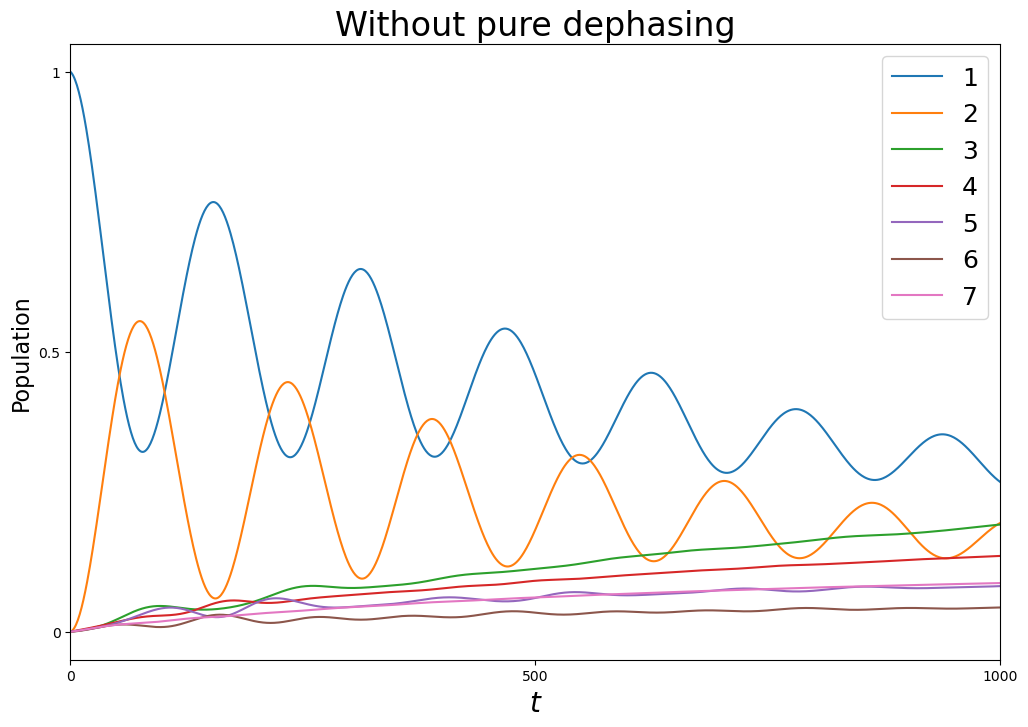

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
for m, Q in enumerate(Q_list):
    axes.plot(
        tlist * 1e6,
        expect(outputFMO_ME_nodephase.states, Q),
        label=m + 1,
    )

axes.set_xlabel(r'$t$', fontsize=20)
axes.set_ylabel(r"Population", fontsize=16)
axes.set_xlim(0, 1000)
axes.set_title('Without pure dephasing', fontsize=24)
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.xticks([0, 500, 1000], [0, 500, 1000])
axes.legend(fontsize=18);

And now we see that without the dephasing, the oscillations reappear. The full dynamics captured by the HEOM are still not capture by this simpler model, however.

## About

In [19]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [20]:
assert np.allclose(
    expect(outputFMO_BR.states, Q_list[0]),
    expect(outputFMO_ME.states, Q_list[0]),
    rtol=2e-2,
)
assert np.allclose(
    expect(outputFMO_BR.states, Q_list[1]),
    expect(outputFMO_ME.states, Q_list[1]),
    rtol=2e-2,
)